Saving continents2.csv to continents2 (1).csv
Saving long_format_annual_surface_temp.csv to long_format_annual_surface_temp (1).csv
Saving co2_emissions_kt_by_country.csv to co2_emissions_kt_by_country (1).csv
Saving methane_hist_emissions.csv to methane_hist_emissions (1).csv
Saving annual-change-forest-area.csv to annual-change-forest-area (1).csv


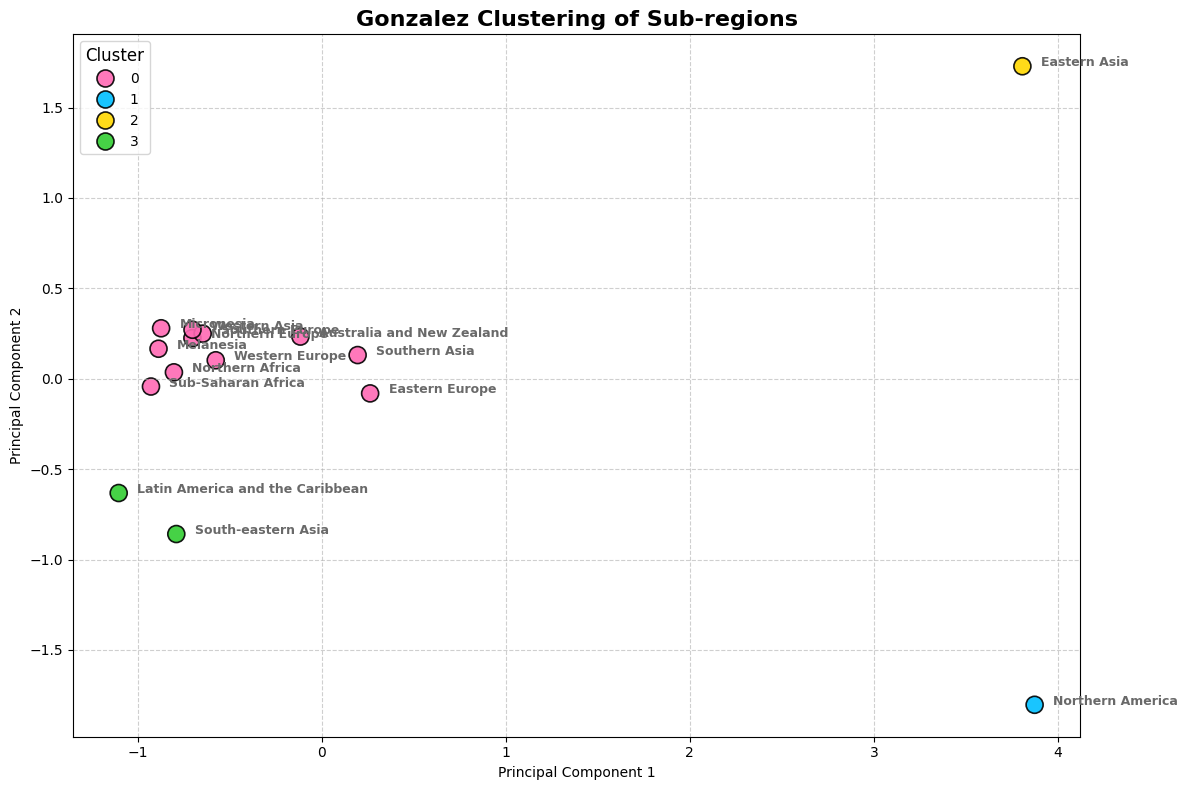

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#file upload
from google.colab import files
uploaded = files.upload()

#load data
continents_df = pd.read_csv("continents2.csv")
co2_df = pd.read_csv("co2_emissions_kt_by_country.csv")
methane_df = pd.read_csv("methane_hist_emissions.csv")
deforestation_df = pd.read_csv("annual-change-forest-area.csv")
temperature_df = pd.read_csv("long_format_annual_surface_temp.csv")

#merge data
subregion_map = continents_df[['alpha-3', 'sub-region']].rename(columns={'alpha-3': 'Code', 'sub-region': 'Sub-region'})
country_name_to_code = continents_df.set_index('name')['alpha-3'].to_dict()

#CO2 data
co2_grouped = co2_df.groupby('country_code')['value'].mean().reset_index()
co2_grouped.columns = ['Code', 'Avg_CO2_Emissions']

#methane data
methane_filtered = methane_df[(methane_df['Sector'] == 'Total excluding LUCF') & (methane_df['Gas'] == 'CH4')]
methane_grouped = methane_filtered.set_index('Country')[[str(y) for y in range(1990, 2019)]].mean(axis=1).reset_index()
methane_grouped.columns = ['Country', 'Avg_Methane_Emissions']
methane_grouped['Code'] = methane_grouped['Country'].map(country_name_to_code)
methane_grouped = methane_grouped.dropna(subset=['Code'])

#deforestation data
deforestation_grouped = deforestation_df.groupby('Code')['Net forest conversion'].mean().reset_index()
deforestation_grouped.columns = ['Code', 'Avg_Deforestation']

#merge all data
merged = pd.merge(subregion_map, co2_grouped, on='Code', how='left')
merged = pd.merge(merged, methane_grouped[['Code', 'Avg_Methane_Emissions']], on='Code', how='left')
merged = pd.merge(merged, deforestation_grouped, on='Code', how='left')
final_grouped = merged.dropna().groupby('Sub-region')[['Avg_CO2_Emissions', 'Avg_Methane_Emissions', 'Avg_Deforestation']].mean().reset_index()

#temperature data
temperature_df['Country_Clean'] = temperature_df['Country'].str.replace(r',.*', '', regex=True).str.strip()
temperature_df['Code'] = temperature_df['Country_Clean'].map(country_name_to_code)
temperature_df = temperature_df.dropna(subset=['Code'])
temp_with_region = pd.merge(temperature_df, subregion_map, on='Code', how='left')
temp_with_region = temp_with_region.dropna(subset=['Sub-region'])
temp_with_region['Temperature'] = pd.to_numeric(temp_with_region['Temperature'], errors='coerce')
avg_temp_by_subregion = temp_with_region.groupby('Sub-region')['Temperature'].mean().reset_index()
avg_temp_by_subregion.columns = ['Sub-region', 'Avg_Temperature']

#one last merge
final_dataset = pd.merge(final_grouped, avg_temp_by_subregion, on='Sub-region', how='left')
cluster_data = final_dataset.dropna().copy()

#PCA
features = ['Avg_CO2_Emissions', 'Avg_Methane_Emissions', 'Avg_Deforestation']
X = cluster_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_data['PCA1'] = X_pca[:, 0]
cluster_data['PCA2'] = X_pca[:, 1]

#Gonzalez Clustering
def gonzalez_clustering(X, k):
    centers = [X[0]]
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(1, k):
        dists = np.array([min(np.linalg.norm(x - c) for c in centers) for x in X])
        new_center = X[np.argmax(dists)]
        centers.append(new_center)
    for i, x in enumerate(X):
        distances = [np.linalg.norm(x - c) for c in centers]
        labels[i] = np.argmin(distances)
    return np.array(centers), labels

centers, gonzalez_labels = gonzalez_clustering(X_scaled, k=4)
cluster_data['Gonzalez_Cluster'] = gonzalez_labels

#plot
palette = ['hotpink', 'deepskyblue', 'gold', 'limegreen']
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cluster_data,
    x='PCA1',
    y='PCA2',
    hue='Gonzalez_Cluster',
    palette=palette,
    s=150,
    edgecolor='black',
    linewidth=1.2,
    alpha=0.9
)


for i in range(cluster_data.shape[0]):
    plt.text(
        cluster_data['PCA1'].iloc[i] + 0.1,
        cluster_data['PCA2'].iloc[i],
        cluster_data['Sub-region'].iloc[i],
        fontsize=9,
        weight='bold',
        color='dimgray'
    )

plt.title("Gonzalez Clustering of Sub-regions", fontsize=16, weight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
